In [33]:
# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# Import torchvision
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics

#Import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# write device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Using {} device'.format(device))

Using cuda device


In [35]:
from PIL import Image


def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [36]:
### Get a dataset fashion MNIST

# Setup Training data

train_data = datasets.FashionMNIST(
    root = 'tf-knugs/datasets',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'tf-knugs/datasets',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)



In [37]:
# Setup data loaders
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset= train_data,
    batch_size = BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset= test_data,
    batch_size= BATCH_SIZE,
    shuffle= True
)

In [38]:
print(f"DataLoaders:{train_dataloader, test_dataloader} ")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders:(<torch.utils.data.dataloader.DataLoader object at 0x7f204014dfd0>, <torch.utils.data.dataloader.DataLoader object at 0x7f2042bdff90>) 
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [39]:
print(len(train_data))
print(len(train_dataloader)*BATCH_SIZE)

60000
60000


In [40]:
#Check out whats inside the training data loader

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [41]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(-0.5, 27.5, 27.5, -0.5)

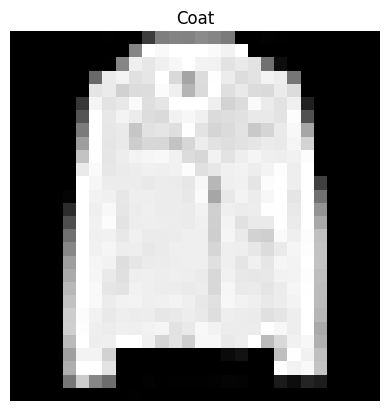

In [42]:
# show sample
# torch.manual_seed(42)
class_names = train_data.classes
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)


In [43]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [44]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to(device) # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [45]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Creating a function to time our expiriment

Machine learning is very expirimental.

Two main things we want ot keep track of is:
1. Model's performance (loss, acc)etc
2. Models spped or how fast it runs

In [46]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [47]:

def print_shape_device(*args):
    """
    This function prints the shape, data type and device of the given tensors or numpy arrays.

    Parameters:
    *args (torch tensor or numpy array): Variable length argument list of tensors or arrays.

    Returns:
    None
    """
    for arg in args:
        if torch.is_tensor(arg):
            print(f"Shape: {arg.shape} | Device: {arg.device}| Type : {arg.dtype} | torch tensor")
        elif isinstance(arg, np.ndarray):
            print(f"Shape: {arg.shape} | Device: CPU | Type : {arg.dtype} | numpy array")
        else:
            print("Input type not supported. Please provide a torch tensor or a numpy array.")

### Creating a training loop and trainin a model pn batches of data

1. Loop throung epoch.
2. Loop through training batches, perform training steps , calculate the train loss *per batch*.
3. Loop through testing batches, perform tetsing steps, claculate the test loos *per batch*.
4. Print out whats happening.
5. Time is all (for analytics and fun).

In [48]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [49]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()


# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    #Train
    train_step(
        model= model_0,
        data_loader= train_dataloader,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy_fn= accuracy_fn,
        device= device
    )

    #test
    test_step(
        model= model_0,
        data_loader= test_dataloader,
        loss_fn= loss_fn,
        accuracy_fn= accuracy_fn,
        device = device
    )


# Calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59039 | Train accuracy: 79.17%
Test loss: 0.51016 | Test accuracy: 82.04%

Epoch: 1
-------
Train loss: 0.47435 | Train accuracy: 83.30%
Test loss: 0.52677 | Test accuracy: 81.68%

Epoch: 2
-------
Train loss: 0.45367 | Train accuracy: 84.19%
Test loss: 0.51264 | Test accuracy: 83.00%

Train time on cuda:0: 52.481 seconds


In [50]:
# make predicitions and get model results

def eval_model(model: torch.nn.Module,
               dataloader: DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn
):
    """Returns a dictonary condataining prediciton parameter of a module

    Args:
        model (torch.nn.Module): model to evaluate
        dataloader (DataLoader): a dataloader that loads data by batches
        loss_fn (torch.nn.Module): function that calculates loss
        accuracy_fn (_type_): function that claculates accuracy
    """
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            # Make predicitons
            y_pred = model(X)

            # Accumulate the loss and accuracy values
            acc += accuracy_fn(y_true= y, y_pred= y_pred.argmax(dim=1))
            loss = loss_fn(y_pred, y)

        #Scale loss and acc to find the average loss/acc per batch
        loss /= len(dataloader)
        acc /= len(dataloader)

    return {
        "model_name" : model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc
    }

In [51]:
# Use the function to calculate
model0_results = eval_model(
    model=model_0,
    dataloader= test_dataloader,
    accuracy_fn= accuracy_fn,
    loss_fn= loss_fn
)
print(model0_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.0010662450222298503, 'model_acc': 83.00718849840256}


### Creatiung a convolutional neural network

In [52]:
class FashionMNISTModelv2(nn.Module):
    """
    Model architechture that replicates the TinyVGG
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels= input_shape,
                out_channels=hidden_units,
                kernel_size= 3,
                stride = 1,
                padding=1), #Setting hyperparameters for 2d data
            nn.ReLU(),
            nn.Conv2d(
                in_channels= hidden_units,
                out_channels= hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1
            ),
            nn.ReLU(),
            nn.MaxPool2d( kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features= hidden_units*7*7,
                out_features= output_shape
            )
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [53]:
torch.manual_seed(42)
model_2 = FashionMNISTModelv2(
    input_shape= 1,
    hidden_units= 10,
    output_shape= len(class_names)
).to(device)

### Train the CNN model

#### Setup a loss and optimizer funciton


In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_2.parameters(),
    lr=0.1
)

In [56]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()


# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    #Train
    train_step(
        model= model_2,
        data_loader= train_dataloader,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy_fn= accuracy_fn,
        device= device
    )

    #test
    test_step(
        model= model_2,
        data_loader= test_dataloader,
        loss_fn= loss_fn,
        accuracy_fn= accuracy_fn,
        device = device
    )


# Calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.30508 | Train accuracy: 89.05%
Test loss: 0.32201 | Test accuracy: 88.24%

Epoch: 1
-------
Train loss: 0.29167 | Train accuracy: 89.30%
Test loss: 0.33901 | Test accuracy: 87.74%

Epoch: 2
-------
Train loss: 0.28126 | Train accuracy: 89.82%
Test loss: 0.32067 | Test accuracy: 88.76%

Train time on cuda:0: 66.765 seconds
